# Libraries Loading

In [1]:
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa # for processing audio input
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

2023-06-11 09:04:03.822830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 09:04:04.807717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-11 09:04:04.807845: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

# Data Preparation & Cleaning

In [2]:
data_path = "./wav/"

file_list = os.listdir(data_path)

file_emotion = []
file_path = []

for file in file_list:
    file_path.append(data_path + file)
    
    em = file[5]
    if em=='W':
        file_emotion.append('angry')
    elif em=='E':
        file_emotion.append('disgust')
    elif em=='A':
        file_emotion.append('fear')
    elif em=='F':
        file_emotion.append('happy')
    elif em=='N':
        file_emotion.append('neutral')
    elif em=='T':
        file_emotion.append('sad')
    elif em=='L':
        file_emotion.append('boredom')

        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
df = pd.concat([emotion_df, path_df], axis=1)
df.head(5)

,emotions,path
0,sad,./wav/14b03Ta.wav
1,neutral,./wav/11b01Nc.wav
2,sad,./wav/11a05Td.wav
3,angry,./wav/09a07Wd.wav
4,neutral,./wav/08b02Nb.wav


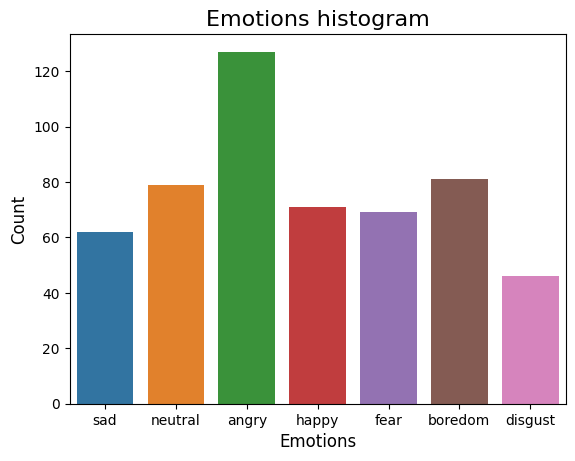

In [3]:
plt.title('Emotions histogram', size=16)
sns.countplot(data=df, x='emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()

## Data agumentation

In [4]:
import librosa.effects

def pitch_shift(data, sr):
    """Apply pitch shifting to an audio signal."""
    n_steps = int(np.random.uniform(low=-5, high = 5))
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

def mix_with_background_noise(data, noise_factor=0.025):
    """Mix an audio signal with background noise"""
    noise_amp = noise_factor*np.random.uniform()*np.amax(data)
    background_noise = noise_amp*np.random.normal(size=data.shape[0])
    return data + background_noise

# Feature Engineering & Modeling

## Audio feature extraction
We'll define some functions for extracting useful features from the input audio

In [5]:
def zcr(data, frame_length=2048, hop_length=512):
    '''Zero crossing rate measures the rate at which the signal changes its sign'''
    return np.squeeze(librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length))

def rmse(data, frame_length=2048, hop_length=512):
    '''Root Mean Square Energy of an audio signal. RMSE is a measure of the energy in the audio signal'''
    return np.squeeze(librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length))

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    '''Extract Mel-frequency Cepstral Coefficients (MFCCs) from an audio signal
    MFCCs are widely used features for representing the spectral characteristics of an audio signal'''
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.ravel(mfcc_feature.T) if flatten else mfcc_feature.T.flatten()

In [6]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    features = np.array([])
    features = np.hstack((features,
                          zcr(data, frame_length, hop_length),
                          rmse(data, frame_length, hop_length),
                          mfcc(data, sr, frame_length, hop_length)
                          ))
    return features

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files
    audio_data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    features1 = extract_features(audio_data, sample_rate)
    result = np.array(features1)

    # data with noise
    noise_data = mix_with_background_noise(audio_data)
    features2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, features2))  # stacking vertically

    # data with pitch shift
    pitch_shifted_data = pitch_shift(audio_data, sample_rate)
    features3 = extract_features(pitch_shifted_data, sample_rate)
    result = np.vstack((result, features3))  # stacking vertically

    # data with pitch shift and noise
    pitch_shifted_data_noise = mix_with_background_noise(pitch_shifted_data)
    features4 = extract_features(pitch_shifted_data_noise, sample_rate)
    result = np.vstack((result, features4))  # stacking vertically

    return result


Now we can extract the features for each of the files in our dataset and build a proper dataframe

In [7]:
X, Y, Paths = [], [], []
for path, emotion in zip(df['path'], df['emotions']):
    features = get_features(path)
    for variant in features:
        X.append(variant)
        Y.append(emotion)
        Paths.append(path.split("/")[-1])


features = pd.DataFrame(X)
features['label'] = Y
features['path'] = Paths
features = features.fillna(0) # remove NaN
features.to_csv('features.csv', index=False)

In [8]:
X = features.drop(columns=['label', 'path'])
Y = features['label']

# We need to autoencode the labels for our classifier
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.to_numpy().reshape(-1,1)).toarray()
    
with open("encoder", "wb") as f:
    pickle.dump(encoder, f)
    f.close()

In [9]:
# splitting data in train, validation and test
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.1, random_state=4, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=4, test_size=0.2, shuffle=True)

# scaling data and making it compatible with the model
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((1540, 2376, 1),
 (1540, 7),
 (214, 2376, 1),
 (214, 7),
 (386, 2376, 1),
 (386, 7))

## Build the model

In [10]:
def build_model():
    model = Sequential()

    # First set of Convolutional and Pooling layers
    model.add(Conv1D(filters=256, kernel_size=5, strides=1, padding="same", activation="relu", input_shape=(x_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

    # Second set of Convolutional and Pooling layers
    model.add(Conv1D(filters=256, kernel_size=5, strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

    # Third set of Convolutional and Pooling layers
    model.add(Conv1D(filters=128, kernel_size=5, strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

    # Flattening the output to connect to Dense layers
    model.add(Flatten())

    # First Dense layer
    model.add(Dense(units=32, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Output Dense layer
    model.add(Dense(units=7, activation="softmax"))

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model


In [12]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2376, 256)         1536      
                                                                 
 batch_normalization_4 (Batc  (None, 2376, 256)        1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1188, 256)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 1188, 256)         327936    
                                                                 
 batch_normalization_5 (Batc  (None, 1188, 256)        1024      
 hNormalization)                                                 
                                                      

In [13]:
# Set up early stopping and learning rate reduction

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0.025,
    patience=30,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-6)

callbacks=[early_stopping,learning_rate_reduction]

In [14]:
history=model.fit(x_train, y_train, batch_size=64, epochs=80, validation_data=(x_val, y_val), callbacks = callbacks)

model.save('model.h5')

Epoch 1/80


2023-06-11 09:12:04.248153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-06-11 09:12:10.372450: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55ae56106090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-11 09:12:10.372499: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-06-11 09:12:11.490958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-11 09:12:14.723073: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 21s 130ms/step - loss: 1.7441 - accuracy: 0.3422 - val_loss: 1.7562 - val_accuracy: 0.2539 - lr: 0.0010
Epoch 2/80
25/25 [==============================] - 3s 112ms/step - loss: 1.2538 - accuracy: 0.5156 - val_loss: 1.7406 - val_accuracy: 0.2487 - lr: 0.0010
Epoch 3/80
25/25 [==============================] - 3s 112ms/step - loss: 1.0348 - accuracy: 0.6026 - val_loss: 2.2829 - val_accuracy: 0.2176 - lr: 0.0010
Epoch 4/80
25/25 [==============================] - 3s 113ms/step - loss: 0.8636 - accuracy: 0.6877 - val_loss: 1.6725 - val_accuracy: 0.3342 - lr: 0.0010
Epoch 5/80
25/25 [==============================] - 3s 113ms/step - loss: 0.8400 - accuracy: 0.6877 - val_loss: 1.9179 - val_accuracy: 0.2228 - lr: 0.0010
Epoch 6/80
25/25 [==============================] - 3s 113ms/step - loss: 0.6882 - accuracy: 0.7708 - val_loss: 1.7616 - val_accuracy: 0.3886 - lr: 0.0010
Epoch 7/80
25/25 [==============================] - 3s 113ms/step - loss: 0.5314

# Results & Visualizations

## Training evolution

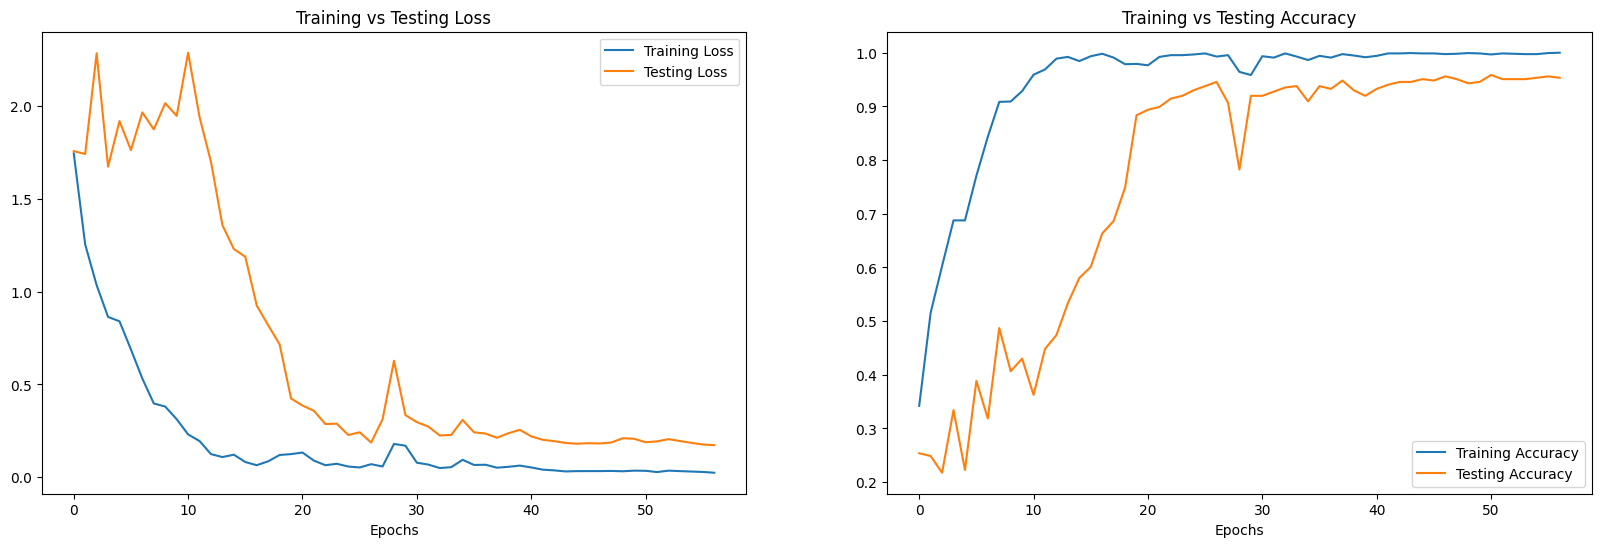

In [15]:
epochs = [i for i in range(early_stopping.stopped_epoch + 1)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
sns.lineplot(x=epochs, y=train_loss, ax=ax[0], label='Training Loss')
sns.lineplot(x=epochs, y=test_loss, ax=ax[0], label='Testing Loss')
ax[0].set_title('Training vs Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

sns.lineplot(x=epochs, y=train_acc, ax=ax[1], label='Training Accuracy')
sns.lineplot(x=epochs, y=test_acc, ax=ax[1], label='Testing Accuracy')
ax[1].set_title('Training vs Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

## Evaluate on test data

In [16]:
y_pred = model.predict(x_test)
y_pred = encoder.inverse_transform(y_pred)
y_test = encoder.inverse_transform(y_test)

7/7 [==============================] - 1s 29ms/step


### Confusion matrix

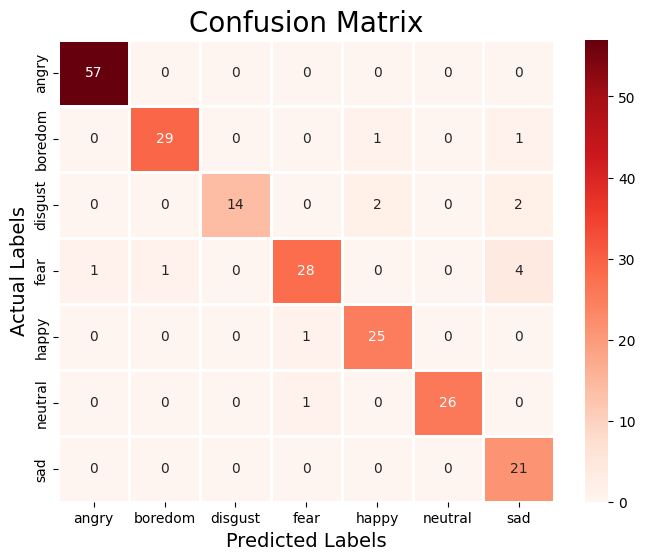

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))

cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_])

sns.heatmap(cm, linecolor='white', cmap='Reds', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)

plt.show()

### Classification report

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.98      1.00      0.99        57
     boredom       0.97      0.94      0.95        31
     disgust       1.00      0.78      0.88        18
        fear       0.93      0.82      0.87        34
       happy       0.89      0.96      0.93        26
     neutral       1.00      0.96      0.98        27
         sad       0.75      1.00      0.86        21

    accuracy                           0.93       214
   macro avg       0.93      0.92      0.92       214
weighted avg       0.94      0.93      0.93       214

